**Transfer learning for Malaria detection**

<table class="tfo-notebook-buttons" align="left">
 
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb?force_kitty_mode=1&force_corgi_mode=1"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
 
</table>

# Introduction to Transfer Learning

A good deep learning model needs enormous training data, computational power, and a lot of time for fine-tuning to achieve satisfactory accuracy. Therefore, it's not possible for every deep learning enthusiast to train a high-performing model from scratch. This is where we can leverage the power of Transfer Learning. Transfer Learning is a method of reusing an already trained model often called a 'pre-trained model' for another similar task. These pre-trained models are usually trained on massive datasets using high-end GPUs.

Transfer learning is useful when you have small datasets and less computational resources. In this case, we can use the weights from the pre-trained model to initialize the weights of the new model. This leads to lower training time as well as lower generalization error.  A pre-trained can be best in the domain but it is necessary that our problem should belong to the same domain as that of the pre-trained model. For instance, a pre-trained model trained on an image segmentation dataset cannot be used for image classification. A carefully developed architecture can extract the features from the input data. That architecture can extract features from slightly different input data as well. In this article, we explore two ways of applying Transfer Learning for image classification:

1. Feature Extraction

2. Fine-tuning

Feature Extraction: In Feature Extraction, we use the representations learned by a previous network to extract meaningful features from new samples. Here we add a new classifier on top of the model so that we can use the feature maps learned previously from the dataset. We only train the final classification layer as the base convolutional layer already contains the feature necessary for classifying images. 

Fine-Tuning: In Fine-tuning, we unfreeze a few of the top layers of the pre-trained model and then train them for a new dataset along with a newly added classifier. This allows their weights to get updated based on the new dataset thus making them more relevant for the specific task. 


# Case study: Malaria parasite classification 

Here we will be using MobileNet V2 which is a convolutional neural network 53 layers deep. This model was trained on more than a million images from the ImageNet database. The pre-trained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224. 


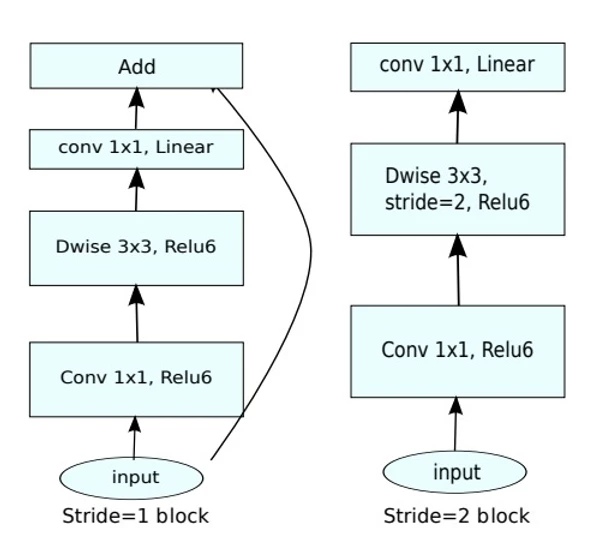

We are using Google colab pro for this case study although that's not a strict requirement. This case study is subdivided into Feature Extraction and Fine Tuning. Steps followed for Feature Extraction:

1. Data loader
2. Data Augmentation and Preprocessing
3. Load pre-trained model, freeze the model's layers 
4. Add a classification layer to form the final model
5. Compile the model, setting up optimizer and loss function
6. Train the model with model.fit

Steps followed for Fine Tuning:
1. Unfreeze the top layers of the model
2. Freeze the layers before which you want to train the model
3. Compile the model with a lower learning rate
4. Continue the training 
5. Evaluation


## Feature extraction

First, we will perform feature extraction where we will just replace the classification head and freeze the other layers so that their weights remain unchanged during training.

**Import necessary libraries**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve,precision_score,recall_score,f1_score,roc_auc_score,roc_curve

**Download the dataset**

The dataset can be downloaded from [here](https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria) and then upload the data to google drive. We will mount the drive in colab and then unzip the file directly from colab to use it.
The command below will start the mounting process:



In [ ]:
# To mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Run the below command to extract the 'malaria cell images.zip' file directly from colab to the local environment

In [ ]:
# !unzip '/content/drive/MyDrive/Datasets/Malaria/malaria cell images.zip' >/dev/null

Once the cell is executed you can see the files have appeared in the local 'malaria cell images' folder. You can find it on the left-hand side of the colab interface.


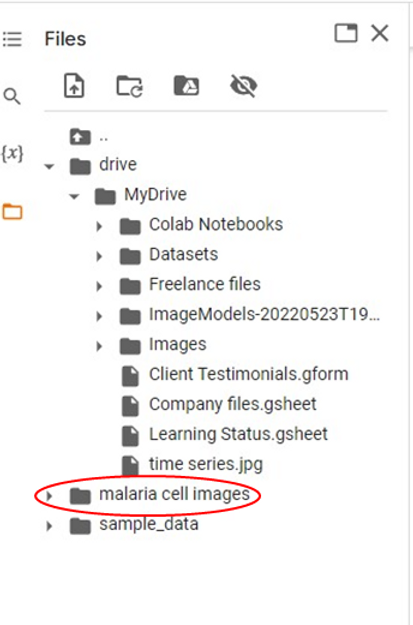

The dataset has two folders named 'Parasitized' and 'Uninfected' and is not split into training, test, and validation. We will load the images into training and validation TensorFlow datasets and will later create a test dataset.


In [ ]:
data_dir = pathlib.Path(r'/content/malaria cell images/cell_images') 
data_dir

PosixPath('/content/malaria cell images/cell_images')

We will use TensorFlow '[image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)' utility to load the data into the training and validation dataset separately.


In [ ]:
# define batch size and image size
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  shuffle = True,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)


val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle = True,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)


Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


Checking the classes present in the 

In [ ]:
class_names = train_ds.class_names
class_names

['Parasitized', 'Uninfected']

We don't have any test dataset in the original dataset thus we will create one. To do so, we will first determine how many batches of data are available in the validation set using 'tf.data.experimental.cardinality', then move 20% of them to a test set.


In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
val_batches 

<tf.Tensor: shape=(), dtype=int64, numpy=44>

So there are 44 batches n the validation datset. We will move 20% i.e. 8 batches to test set.

In [ ]:
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds)) 

Number of validation batches: 36
Number of test batches: 8


**Now let’s plot some images**

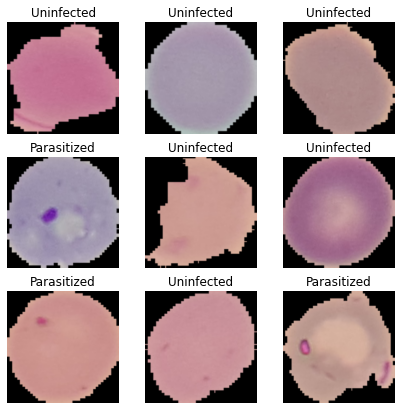

In [ ]:
plt.figure(figsize=(7, 7))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Configure the dataset for performance**

To load images without I/O blocking we can use buffered prefetching. To learn more about this method check [this](https://www.tutorialspoint.com/how-can-tensorflow-be-used-to-configure-the-dataset-for-performance).

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE 
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE) 

**Data Augmentation and preprocessing**

You can add some data augmentation to images to increase dataset size to prevent overfitting, e.g. flip horizontally or vertically, rotation to add diversity to the training images. We don't apply any augmentation to our validation and test datasets since that is used to evaluate our model's performance.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.3),
]) 

Let's repeatedly apply these layers to the same image and see the result

(224, 224, 3)


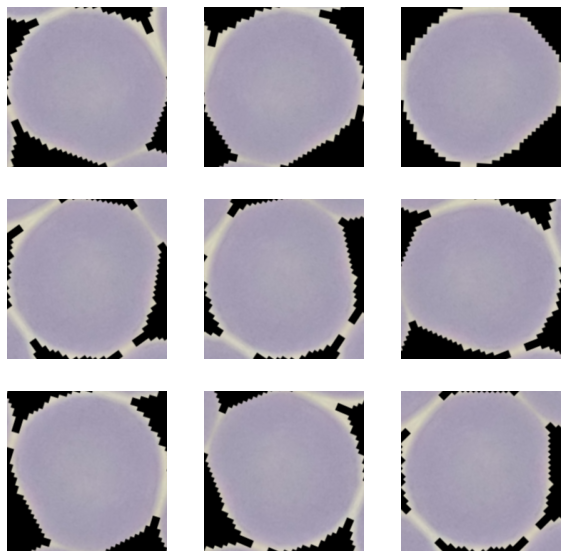

In [ ]:
for image, _ in test_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  print(first_image.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off') 

Rescale pixel values

The pixel range in the images is between [0,255] but MobileNet V2 expects them to be in [-1,1]. We will use preprocessing method 'tf.keras.applications.mobilenet_v2.preprocess_input' to rescale the images.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input 

**Create base model**

Let's initialize the model with weights trained on ImageNet dataset by using weights= 'imagenet'. We will load the network without the classification head by specifying include_top=False which is ideal for feature extraction.


In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') 


**Freeze the convolutional base**

Freezing stands for preventing the model weights from getting updated during training. this is done by setting the layer.trainable = False. 
Since MobileNet V2 has many layers so we can freeze all of them by the following command.

In [ ]:
base_model.trainable = False

**Add a classification head**

To generate predictions from the block of features, average over the spatial 7x7 spatial locations, using a 'tf.keras.layers.GlobalAveragePooling2D' layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a 'tf.keras.layers.Dense' layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1) 

Build a model by chaining the data augmentation, rescaling, base_model, and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs) 

Check the model summary

In [ ]:
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

We can see the number of trainable params as 1281 which is same as the number of params in the last layer.

**Compile the model**

Specify optimizer and loss function. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy loss with from_logits=True since the model provides a linear output.

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Train the model**

In [ ]:
initial_epochs = 10
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds) 

Epoch 1/10
173/173 [==============================] - 40s 135ms/step - loss: 0.4162 - accuracy: 0.7966 - val_loss: 0.2594 - val_accuracy: 0.8839
Epoch 2/10
173/173 [==============================] - 21s 121ms/step - loss: 0.2669 - accuracy: 0.8885 - val_loss: 0.2236 - val_accuracy: 0.9216
Epoch 3/10
173/173 [==============================] - 21s 121ms/step - loss: 0.2420 - accuracy: 0.9046 - val_loss: 0.2094 - val_accuracy: 0.9253
Epoch 4/10
173/173 [==============================] - 21s 121ms/step - loss: 0.2319 - accuracy: 0.9079 - val_loss: 0.2043 - val_accuracy: 0.9302
Epoch 5/10
173/173 [==============================] - 21s 121ms/step - loss: 0.2295 - accuracy: 0.9101 - val_loss: 0.2005 - val_accuracy: 0.9327
Epoch 6/10
173/173 [==============================] - 21s 121ms/step - loss: 0.2269 - accuracy: 0.9112 - val_loss: 0.2028 - val_accuracy: 0.9327
Epoch 7/10
173/173 [==============================] - 21s 121ms/step - loss: 0.2214 - accuracy: 0.9159 - val_loss: 0.1984 - val_ac

After just 10 epochs the model was able to obtain a validation accuracy of 93.45%.


**Plotting Learning curves**

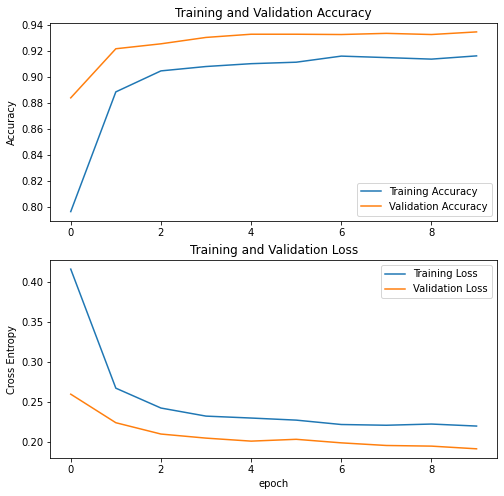

In [ ]:

# Accuracy and Loss vs Epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
loss = history.history['loss']
val_loss = history.history['val_loss']
 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
 
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because of layers like 'tf.keras.layers.BatchNormalization' and 'tf.keras.layers.Dropout' affect accuracy during training. They are turned off when calculating validation loss.

# Fine Tuning

In the feature extraction, we were only training a few layers on top of a MobileNet V2 base model. The weights of the pre-trained network were not updated during training.
One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.
Note: This should only be attempted after we have trained the top-level classifier with the pre-trained model set to non-trainable. If we add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly. In that case, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.
Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.


**Un-freeze the top layers of the model**

In [ ]:
base_model.trainable = True 

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


Now freeze the layers before which you want to train the model. In this case, we will train the layers from the 100th layer onwards thus we will freeze every layer before it.


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100
 
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False 

**Compile the model**

As you are training a much larger model and want to readapt the pre-trained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [ ]:
model.compile(loss =tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy']) 

**Continue training the model**

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
 
history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds) 

Epoch 10/20
173/173 [==============================] - 34s 168ms/step - loss: 0.3687 - accuracy: 0.8788 - val_loss: 0.1706 - val_accuracy: 0.9485
Epoch 11/20
173/173 [==============================] - 28s 164ms/step - loss: 0.1551 - accuracy: 0.9512 - val_loss: 0.1247 - val_accuracy: 0.9603
Epoch 12/20
173/173 [==============================] - 28s 164ms/step - loss: 0.1393 - accuracy: 0.9560 - val_loss: 0.1156 - val_accuracy: 0.9608
Epoch 13/20
173/173 [==============================] - 28s 164ms/step - loss: 0.1318 - accuracy: 0.9560 - val_loss: 0.1223 - val_accuracy: 0.9610
Epoch 14/20
173/173 [==============================] - 28s 164ms/step - loss: 0.1265 - accuracy: 0.9586 - val_loss: 0.1136 - val_accuracy: 0.9610
Epoch 15/20
173/173 [==============================] - 28s 164ms/step - loss: 0.1190 - accuracy: 0.9610 - val_loss: 0.1742 - val_accuracy: 0.9512
Epoch 16/20
173/173 [==============================] - 28s 165ms/step - loss: 0.1155 - accuracy: 0.9616 - val_loss: 0.1133 -

The validation accuracy increased from 93.45% to 96.66% which is a significant improvement thus showing the performance increase via fine-tuning.

**Let’s see the learning curves**

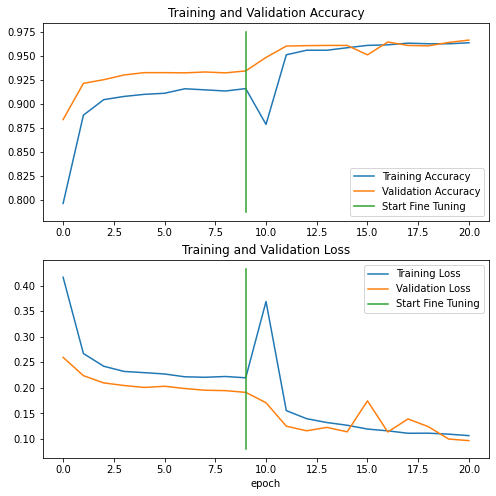

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
 
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss'] 

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show() 

**Evaluation**

Now let’s check the model’s accuracy on unseen test data

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy) 

8/8 [==============================] - 3s 171ms/step - loss: 0.1054 - accuracy: 0.9658
Test accuracy : 0.9658203125


Prediction on a few test images

Predictions:
 [0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0
 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1
 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1
 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1]
Labels:
 [0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0
 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1
 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1
 1 1 0 1 1 0 1 1 0 1 0 0 1 1 0 0 1]


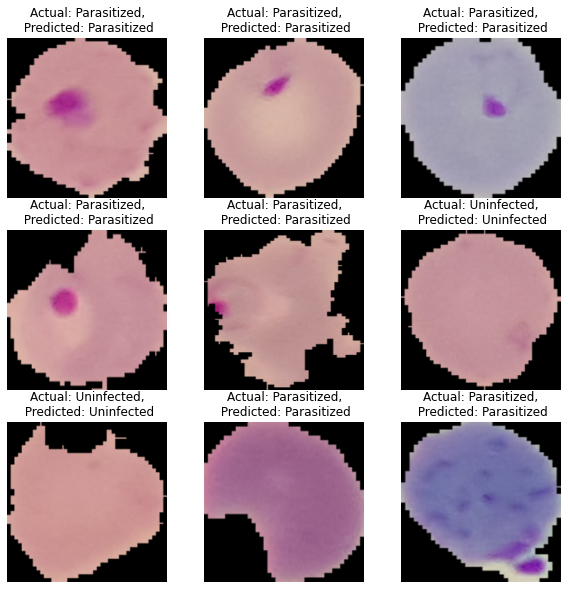

In [ ]:

# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
 
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
 
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
 
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  actual_class = class_names[predictions[i]]
  predicted_class = class_names[label_batch[i]]
 
  plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}")
 
  plt.axis("off")

Let’s plot the confusion matrix to visualize the accuracy with percentages rather than using just the number.

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Get the predictions and plot the confusion matrix using the function defined above:


Confusion Matrix


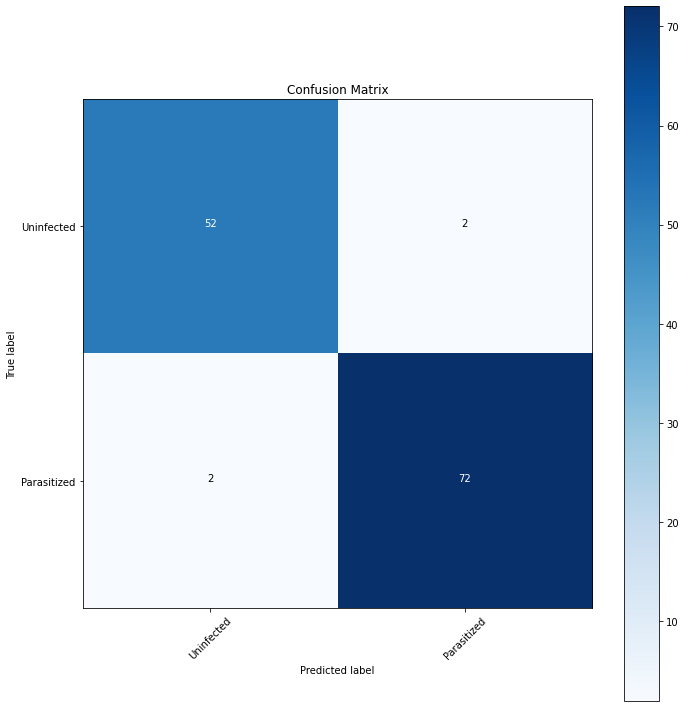

In [ ]:
target_names = ["Uninfected", "Parasitized"]
image_batch, label_batch = test_ds.as_numpy_iterator().next()
y_pred = (model.predict(image_batch) > 0.5).astype("int32").reshape(-1)
y_test_c = label_batch

print('Confusion Matrix')
cm = confusion_matrix(y_test_c, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix') 

Let’s get Precision Score, Recall score F1 Score, and ROC Score. You can learn more about these matrices [here](https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/).

In [ ]:
print("Precision Score -", precision_score(label_batch,y_pred)*100,"%")
print("Recall Score    -", recall_score(label_batch,y_pred)*100,"%")
print("F1 Score        -", f1_score(label_batch,y_pred)*100,"%")
print("ROC Score        -", roc_auc_score(label_batch,y_pred)*100,"%") 

Precision Score - 97.2972972972973 %
Recall Score    - 97.2972972972973 %
F1 Score        - 97.2972972972973 %
ROC Score        - 96.79679679679681 %


**Conclusion**

In this article, we explored transfer learning, with examples of how to use it to develop models for image classification. We used a pre-trained model MobileNet V2 for our case, you can use any pre-trained model you like. I hope you enjoyed it, thank you for reading!

**About us**

We at Picaso Analytics offer various services in the field of Data Science and Analytics. We have worked with more than 30 clients from different parts of the world. We have worked on several projects involving concepts from NLP, Transfer Learning, Machine Learning, Deep Learning, Bayesian Optimization, Scientific Machine Learning, and Tableau dashboarding.

Check out our project section to know more: [Projects](https://www.picasoanalytics.com/s-projects-side-by-side)

Reach out to us at 'picasoanalytics@gmail.com' 

Connect with us on [LinkedIn](https://www.linkedin.com/company/picaso-analytics/?viewAsMember=true).